In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import sys
import h5py

In [2]:
sys.path.append('/home/surajrai1900/iwcd_gbdt')
sys.path.append('/home/surajrai1900/WatChMaL')

In [3]:
import bdt_analysis
import train_test_tree
import utils
import analysis.utils.math as math
from analysis.read import FiTQunOutput
import analysis.utils.binning as bins

Imported analysis code from WatChMaL repository with git version: 0ed2fbb-dirty


/home/surajrai1900/WatChMaL/analysis/__init__.py:4: UserWarning: WARNING: The git repository has uncommitted changes. Please commit changes before running WatChMaL code for proper version control
  print(f"Imported analysis code from WatChMaL repository with git version: {get_git_version(os.path.dirname(__file__))}")


In [4]:
idxs_path = '/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/index_lists/4class_e_mu_gamma_pi0/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
test_idxs  =  np.load(idxs_path, allow_pickle=True)['test_idxs']
data_path = "/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
h5_file = h5py.File(data_path, "r")

In [5]:
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()
events_hits_index = np.append(h5_file['event_hits_index'], h5_file['hit_pmt'].shape[0])
h5_nhits      = (events_hits_index[test_idxs+1] - events_hits_index[test_idxs]).squeeze()

In [6]:
# create dictionary with keys of the unique root_files
root_file_index = dict.fromkeys(h5_root_files)
# update the values so each root file key has a value from 0 to the number of files
root_file_index.update((k, i) for i, k in enumerate(root_file_index))
# create array of root_file_indices of each event in the h5_root_files array
root_file_indices = np.vectorize(root_file_index.__getitem__)(h5_root_files)
# create the array of offsets from the root_file_indices and the h5_event_ids
h5_fq_offsets = 3000*root_file_indices + h5_event_ids

In [7]:
file_path = '/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/fiTQun/'
labels = ['gamma', 'e-', 'mu-', 'pi0']
labels_index = [0, 1, 2, 3]
fq_files = [file_path + f'IWCD_mPMT_Short_{i}_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root' for i in labels]

In [8]:
fq = FiTQunOutput(fq_files)

In [9]:
reco_e_pos = np.array(fq.electron_position)
reco_mu_pos = np.array(fq.muon_position)
reco_pi0_pos = np.array(fq.pi0_position)

reco_e_angles = math.angles_from_direction(np.array(fq.electron_direction))
reco_mu_angles = math.angles_from_direction(np.array(fq.muon_direction))
reco_pi0_angles = math.angles_from_direction(np.array(fq.pi0_direction))

reco_e_dwall = math.dwall(reco_e_pos)
reco_mu_dwall = math.dwall(reco_mu_pos)
reco_pi0_dwall = math.dwall(reco_pi0_pos)

reco_e_towall = math.towall(reco_e_pos, reco_e_angles)
reco_mu_towall = math.towall(reco_mu_pos, reco_mu_angles)
reco_pi0_towall = math.towall(reco_pi0_pos, reco_pi0_angles)


/home/surajrai1900/WatChMaL/analysis/utils/math.py:41: RuntimeWarning: invalid value encountered in sqrt
  towall_barrel = (-b + np.sqrt(b**2-a*c)) / a
/home/surajrai1900/WatChMaL/analysis/utils/math.py:41: RuntimeWarning: invalid value encountered in true_divide
  towall_barrel = (-b + np.sqrt(b**2-a*c)) / a


In [10]:
def combine(values):
    events = values.sum(axis = 0)
    return events.astype(bool)

In [11]:
h5_reco_mom_e = np.array(fq.electron_momentum[h5_fq_offsets])
h5_reco_mom_mu = np.array(fq.muon_momentum[h5_fq_offsets])
h5_reco_mom_pi0 = np.array(fq.pi0_momentum[h5_fq_offsets])

h5_momentum   =  math.momentum_from_energy(h5_energies, h5_labels)
h5_towall = math.towall(h5_positions, h5_angles)
h5_dwall = math.dwall(h5_positions)

h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()

h5_reco_e_dwall = reco_e_dwall[h5_fq_offsets]
h5_reco_mu_dwall = reco_mu_dwall[h5_fq_offsets]
h5_reco_pi0_dwall = reco_pi0_dwall[h5_fq_offsets]

h5_reco_e_towall = reco_e_towall[h5_fq_offsets]
h5_reco_mu_towall = reco_mu_towall[h5_fq_offsets]
h5_reco_pi0_towall = reco_pi0_towall[h5_fq_offsets]


In [12]:
bins_e_mom = bins.get_binning(h5_reco_mom_e[h5_labels == 1], bins = 100, minimum = 0, maximum = 2000)
bins_indices_reco_e = bins_e_mom[1]
bins_e_true_mom = bins.get_binning(h5_momentum[h5_labels == 1], bins = 100, minimum = 0, maximum = 2000)
bins_indices_true_e = bins_e_true_mom[1]

bins_mu_mom = bins.get_binning(h5_reco_mom_mu[h5_labels == 2], bins = 100, minimum = 0, maximum = 2000)
bins_indices_reco_mu = bins_mu_mom[1]
bins_mu_true_mom = bins.get_binning(h5_momentum[h5_labels == 2], bins = 100, minimum = 0, maximum = 2000)
bins_indices_true_mu = bins_mu_true_mom[1]

bins_pi0_mom = bins.get_binning(h5_reco_mom_pi0[h5_labels == 3], bins = 100, minimum = 0, maximum = 2000)
bins_indices_reco_pi0 = bins_pi0_mom[1]
bins_pi0_true_mom = bins.get_binning(h5_momentum[h5_labels == 3], bins = 100, minimum = 0, maximum = 2000)
bins_indices_true_pi0 = bins_pi0_true_mom[1]

In [13]:
diagonal_cut_e = np.array([((bins_indices_reco_e == i) & (bins_indices_true_e == i)) for i in range(1, 102)])
diagonal_cut_mu = np.array([((bins_indices_reco_mu == i) & (bins_indices_true_mu == i)) for i in range(1, 102)])
diagonal_cut_pi0 = np.array([((bins_indices_reco_pi0 == i) & (bins_indices_true_pi0 == i)) for i in range(1, 102)])

diagonal_e = combine(diagonal_cut_e)
diagonal_mu = combine(diagonal_cut_mu)
diagonal_pi0 = combine(diagonal_cut_pi0)
diagonal_gamma = h5_labels[h5_labels == 0]

In [14]:
diagonal_cut = np.concatenate([diagonal_gamma, diagonal_e, diagonal_mu, diagonal_pi0])

In [15]:
def df_pandas(index):    
    dict_vals = {}
    dict_vals['h5_momentum'] = h5_momentum[h5_labels == index]
    dict_vals['h5_towall'] = h5_towall[h5_labels == index]
    dict_vals['h5_dwall'] = h5_dwall[h5_labels == index]
    dict_vals['h5_reco_mom_e'] = h5_reco_mom_e[h5_labels == index]
    dict_vals['h5_reco_mom_mu'] = h5_reco_mom_mu[h5_labels == index]
    dict_vals['h5_reco_mom_pi0'] = h5_reco_mom_pi0[h5_labels == index]
    dict_vals['h5_reco_e_dwall'] = h5_reco_e_dwall[h5_labels == index]
    dict_vals['h5_reco_mu_dwall'] = h5_reco_mu_dwall[h5_labels == index]
    dict_vals['h5_reco_pi0_dwall'] = h5_reco_pi0_dwall[h5_labels == index]
    dict_vals['h5_reco_e_towall'] = h5_reco_e_towall[h5_labels == index]
    dict_vals['h5_reco_mu_towall'] = h5_reco_mu_towall[h5_labels == index]
    dict_vals['h5_reco_pi0_dwall'] = h5_reco_pi0_towall[h5_labels == index]
    dict_vals['h5_vetos'] = h5_vetos[h5_labels == index]
    dict_vals['sig'] = diagonal_cut[h5_labels == index]

    df = pd.DataFrame(dict_vals)
    return df

In [16]:
df = df_pandas(1)
df

,h5_momentum,h5_towall,h5_dwall,h5_reco_mom_e,h5_reco_mom_mu,h5_reco_mom_pi0,h5_reco_e_dwall,h5_reco_mu_dwall,h5_reco_pi0_dwall,h5_reco_e_towall,h5_reco_mu_towall,h5_vetos,sig
0,245.001085,190.761574,64.608521,206.956848,404.032379,174.225952,78.522018,81.258606,222.422247,180.486992,138.650068,False,0
1,855.768398,337.385819,67.418274,842.675598,953.902283,852.125244,75.189301,68.652374,365.440257,348.900632,395.226697,False,1
2,597.023336,138.040446,60.461700,233.178909,515.416809,256.429962,77.010956,82.076202,212.642671,151.587330,162.264948,False,0
3,402.785832,251.795181,176.367126,382.876282,717.984741,380.084259,176.663071,186.916916,302.117004,251.733536,269.217957,False,0
4,830.345780,267.159357,187.088364,906.258545,947.274719,896.135437,188.501816,171.798233,326.528673,259.277523,372.559954,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177961,233.741478,286.318447,90.949417,246.317719,473.530609,251.694260,88.268677,84.020935,319.846876,302.831977,341.878165,False,0
1177962,76.400138,47.735718,42.352966,47.053440,224.656464,89.081116,28.691895,31.922180,78.648987,36.108917,39.931274,False,0
1177963,966.660871,276.619362,164.137390,1060.800903,1395.338989,1042.614746,176.220901,167.305939,335.428702,291.237657,422.852404,False,0
1177964,776.515447,475.442017,36.961853,776.103271,827.683777,781.927734,49.248810,45.450897,497.667969,475.733521,507.673065,False,1


In [17]:
model = train_test_tree.CutEngine(df, train_col = ['h5_momentum', 'h5_towall', 'h5_dwall', 'sig'], lr = 0.1)

using gbdt model


In [18]:
model.train()

[0.47664272 0.60698672 0.35871607 ... 0.02672338 0.23283402 0.30998689]


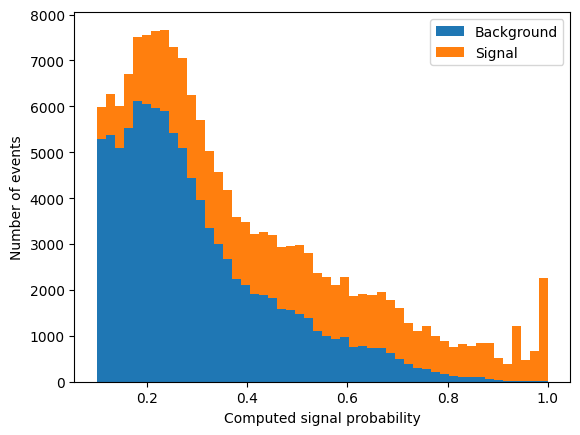

<Figure size 640x480 with 0 Axes>

In [19]:
test_prob = model.rf_model.predict_proba(model.X_test_scaled)[:,1]
print(test_prob)
model.plot_probs(test_prob)

In [20]:
test_f1, prec, rec = model.test()


In [21]:
print(test_f1, prec, rec)

0.5266087698269712 0.4951770489762897 0.7714507319910804


In [22]:
feature_imp = model.get_features_importances()
print(feature_imp)

{'h5_momentum': 0.6264516137147141, 'h5_towall': 0.32189738263317935, 'h5_dwall': 0.0516510036521064}


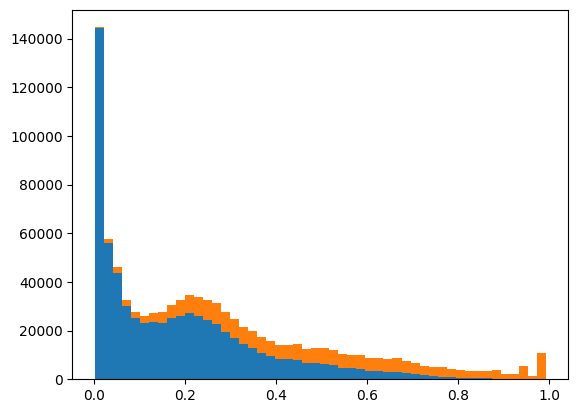

(0.6250782149230211, 0.7656794095382287, 0.32587613670229476)

In [23]:
model.test_on_train()

In [24]:
model.best_thresh

0.26153846153846155

In [16]:
df = df_pandas(2)
df

,h5_momentum,h5_towall,h5_dwall,h5_reco_mom_e,h5_reco_mom_mu,h5_reco_mom_pi0,h5_reco_e_dwall,h5_reco_mu_dwall,h5_reco_pi0_dwall,h5_reco_e_towall,h5_reco_mu_towall,h5_vetos,sig
0,390.431045,190.761574,64.608521,195.601089,396.211212,182.222870,96.302521,69.485870,236.576526,153.853203,190.813670,False,1
1,366.958181,116.690399,64.063889,198.519302,365.972717,143.889603,58.443497,65.958130,94.797974,93.373962,122.936218,False,1
2,820.022567,157.898254,146.082779,401.116699,500.035950,382.356476,130.241394,144.116730,191.744995,130.958557,162.748840,True,0
3,245.318675,162.169028,4.677948,70.471001,290.330841,35.003506,11.607086,7.784149,123.351176,69.992909,104.375438,False,0
4,190.499196,57.558180,39.656494,25.277693,189.667313,27.085699,32.237762,54.290863,70.851217,36.393268,61.813642,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164134,579.695268,491.248047,31.538849,328.118530,534.324768,322.024109,47.647659,35.816620,264.857056,286.661499,540.725586,False,0
1164135,1001.043398,178.580150,129.652344,400.317322,543.000122,404.001007,138.309235,151.574570,198.652914,175.155650,191.757191,True,0
1164136,945.693831,33.418060,31.273712,18.327209,187.888229,31.908281,9.576324,9.564362,NaN,597.651026,398.410923,True,0
1164137,889.349346,372.878450,298.996674,771.922607,916.760193,797.359070,280.669922,293.031433,377.780664,326.482257,384.074852,False,0


In [17]:
model = train_test_tree.CutEngine(df, train_col = ['h5_momentum', 'h5_towall', 'h5_dwall', 'sig'], lr = 0.1)

using gbdt model


In [18]:
model.train()

[0.42670733 0.35279443 0.03613873 ... 0.01149272 0.00693614 0.35046379]


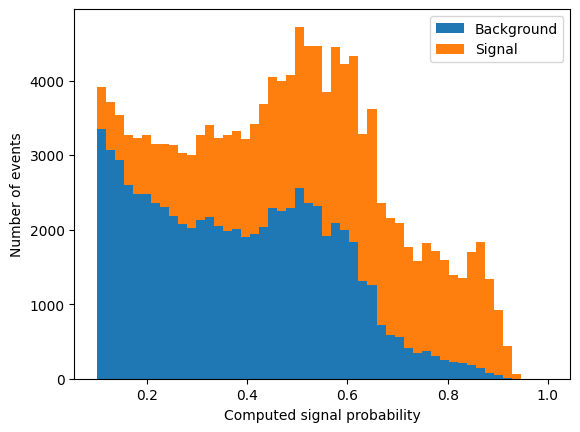

<Figure size 640x480 with 0 Axes>

In [19]:
test_prob = model.rf_model.predict_proba(model.X_test_scaled)[:,1]
print(test_prob)
model.plot_probs(test_prob)

In [20]:
test_f1, prec, rec = model.test()


In [22]:
print(test_f1, prec, rec)

0.570144556505858 0.5312850435337557 0.8988739780965602


In [21]:
feature_imp = model.get_features_importances()
print(feature_imp)

{'h5_momentum': 0.6082175247432982, 'h5_towall': 0.3477902644672375, 'h5_dwall': 0.043992210789464366}


In [16]:
df = df_pandas(2)
df

,h5_momentum,h5_towall,h5_dwall,h5_reco_mom_e,h5_reco_mom_mu,h5_reco_mom_pi0,h5_reco_e_dwall,h5_reco_mu_dwall,h5_reco_pi0_dwall,h5_reco_e_towall,h5_reco_mu_towall,h5_vetos,sig
0,390.431045,190.761574,64.608521,195.601089,396.211212,182.222870,96.302521,69.485870,236.576526,153.853203,190.813670,False,1
1,366.958181,116.690399,64.063889,198.519302,365.972717,143.889603,58.443497,65.958130,94.797974,93.373962,122.936218,False,1
2,820.022567,157.898254,146.082779,401.116699,500.035950,382.356476,130.241394,144.116730,191.744995,130.958557,162.748840,True,0
3,245.318675,162.169028,4.677948,70.471001,290.330841,35.003506,11.607086,7.784149,123.351176,69.992909,104.375438,False,0
4,190.499196,57.558180,39.656494,25.277693,189.667313,27.085699,32.237762,54.290863,70.851217,36.393268,61.813642,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164134,579.695268,491.248047,31.538849,328.118530,534.324768,322.024109,47.647659,35.816620,264.857056,286.661499,540.725586,False,0
1164135,1001.043398,178.580150,129.652344,400.317322,543.000122,404.001007,138.309235,151.574570,198.652914,175.155650,191.757191,True,0
1164136,945.693831,33.418060,31.273712,18.327209,187.888229,31.908281,9.576324,9.564362,NaN,597.651026,398.410923,True,0
1164137,889.349346,372.878450,298.996674,771.922607,916.760193,797.359070,280.669922,293.031433,377.780664,326.482257,384.074852,False,0


In [17]:
model = train_test_tree.CutEngine(df, train_col = ['h5_momentum', 'h5_towall', 'h5_dwall', 'sig'], lr = 0.1)

using gbdt model


In [18]:
model.train()

[0.41781073 0.34604932 0.04115978 ... 0.01353464 0.00465812 0.36111846]


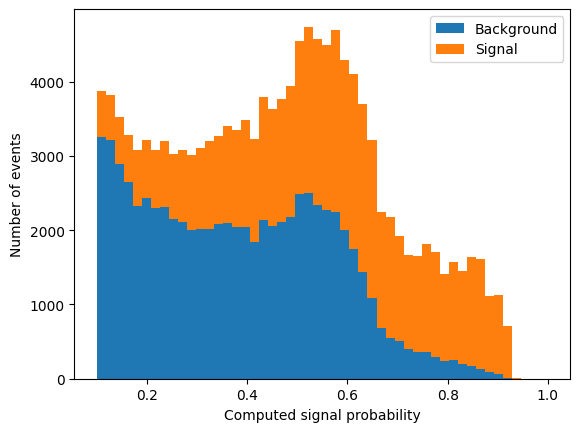

<Figure size 640x480 with 0 Axes>

In [19]:
test_prob = model.rf_model.predict_proba(model.X_test_scaled)[:,1]
print(test_prob)
model.plot_probs(test_prob)

In [20]:
test_f1, prec, rec = model.test()


In [22]:
print(test_f1, prec, rec)

0.575542673592813 0.5379664292885223 0.8844207928428197
